### Based on the paper from Goodwill et al.

In [147]:
import numpy as np
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from tools.nbloader import NotebookLoader
from scipy import stats

trace_len = 50
sample_size = 350

def gen_trace(key=0, mu=128):
    return np.array([np.random.normal(0 + (key/256 - 1), 1, trace_len) for _ in range(sample_size)])

def gen_mask_trace(mu=128):
    random_keys = np.random.uniform(0, 256, sample_size) / 256

    return np.array([np.random.normal(mu + (rk - 1), 1, trace_len) for rk in random_keys])

tg_a1 = gen_trace(0)
tg_a2 = gen_trace(256)
tg_b = gen_mask_trace()

In [161]:
def confidence_level(all_t_values, p=.95):
    tvs_flat = abs(all_t_values.flatten())
    n = round(len(tvs_flat) * p)

    return sorted(tvs_flat)[n]

def device_fails(ta: np.array, tb: np.array, c=2.5):
    """
    @param ta should be a positive-valued array of t-test results from some power trace with given key.
    @param tb should be a positive-valued array of t-test results from a different set of traces with the same key.
    @param c should be the confidence value.
    """
    return np.array((ta >= c) * (tb >= c)).any()

def t_test(a, b):
    num = a.mean(axis=0) - b.mean(axis=0)
    den = (((a.var(axis=0) / len(a)) + (b.var(axis=0) / len(b))) ** .5)

    return np.array(num / den)

def gen_one():
    return np.array([stats.norm.rvs(loc=5,scale=.1,size=50) for _ in range(350)])

def gen_two():
    return np.array([stats.norm.rvs(loc=6,scale=.1,size=50) for _ in range(350)])

tvs = gen_one()
print(confidence_level(tvs))

5.162220394133096


In [162]:
def stats_t_test(a, b):
    return stats.ttest_ind(a, b, equal_var=False)[0]


def bench(test):
    acc = [(False, False)]
    for _ in tqdm(range(100)):
        tk1 = abs(np.array(test(gen_one(), gen_one())))
        tk2 = abs(np.array(test(gen_one(), gen_one())))
        tm1 = abs(np.array(test(gen_one(), gen_two())))
        tm2 = abs(np.array(test(gen_one(), gen_two())))

        c_value = np.percentile(np.array([*tk1, *tk2, *tm1, *tm2]).flatten(), 95)

        res = np.array((device_fails(tk1, tk2, c_value), device_fails(tm1, tm2, c_value)))
        if res.any():
            acc.append(res)

    return np.array(acc).sum(axis=0)

bench(t_test)

100%|██████████| 100/100 [00:10<00:00,  9.46it/s]


array([ 0, 47])

In [150]:
rvs1 = stats.norm.rvs(loc=5,scale=10,size=500)
rvs2 = stats.norm.rvs(loc=5,scale=10,size=500)
rvs3 = stats.norm.rvs(loc=5, scale=20, size=500)
rvs4 = stats.norm.rvs(loc=5, scale=20, size=100)
rvs5 = stats.norm.rvs(loc=8, scale=20, size=100)

In [151]:
stats.ttest_ind(gen_trace(), gen_trace())[0]

array([ 0.60420246,  0.66097823, -0.24248201,  0.36156444, -0.76877828,
       -1.68062625, -0.01359138, -1.56212222, -0.99496863,  0.89988549,
       -0.70611479,  1.35805091, -1.00940486,  1.43929501,  0.30364248,
       -0.06696747,  0.43580473, -0.51750891, -1.30578777, -0.54605284,
       -0.7241662 , -0.51000194,  1.82387337,  1.79333042,  0.63293527,
       -0.28211483, -0.31106338, -0.63602224,  2.35901462,  0.50255987,
       -0.31513772,  0.58018831, -0.74771554, -0.13776733,  0.65872628,
       -2.22555065,  0.60707746,  0.08483823, -2.40816681, -1.00141452,
        0.59613517,  0.0220641 , -1.01514276,  1.44397127, -0.73761172,
       -0.58312101, -0.8029458 ,  1.10568465,  1.71027782,  0.76776675])

In [152]:
def t_stat(traces):
    a, b = np.array_split(traces, 2)

    num = a.mean(axis=0) - b.mean(axis=0)
    den = (((a.var(axis=0) / len(a)) + (b.var(axis=0) / len(b))) ** .5)

    return np.array(num / den)

def key_t(traces_key, traces_masked, poi=(None, None)):
    ka, kb = np.array_split(traces_key[:, poi[0]:poi[1]], 2)
    ma, mb = np.array_split(traces_masked[:, poi[0]:poi[1]], 2)

    return t_stat(ka), t_stat(kb), t_stat(ma), t_stat(mb)

def key_tvs():
    keys = 256

    tvs = np.array([[np.zeros(trace_len)] * 4] * keys)
    for k in range(keys):
        tvs[k] = key_t(gen_trace(k), gen_mask_trace())

    return tvs

Test whether Moriadi method shows same result

In [153]:
trc_k = gen_trace()

t_stat(trc_k)

nb = NotebookLoader().load_module("welch_t_test")

tp = nb.TraceProcessor()

tp.add_trace(trc_k)

tp.t_test(gen_trace())

importing Jupyter notebook from welch_t_test.ipynb
-2.813529040013576 -2029.7823644581683


18.80402837548303

Example extracting mean and variance from contingency table.

In [154]:
trc = np.array([round(np.random.uniform(0, 255)) for _ in range(100000)])

def ctable_mv(ctable: np.array, num_observations: int):
    """
    Calculates the mean and variance from a contingency table with a corresponding number of observations.
    """
    # Using 128-bit floats prevents some rounding errors when comparing with the np implementation of var and mean.
    ixs = np.arange(0, len(ctable), dtype=np.float128)

    mu = (ctable * ixs).sum() / num_observations
    sigma2 = ((ctable * ixs ** 2).sum() / num_observations) - (mu ** 2)

    return mu, sigma2

print(ctable_mv(np.bincount(trc, minlength=256), len(trc)))

# Actual mean and variance
trc.mean(), trc.var()

(127.65611, 5409.4600496679)


(127.65611, 5409.4600496678995)

In [155]:
def welch_t_test(ctable_a, num_a, ctable_b, num_b):
    ma, va = ctable_mv(ctable_a, num_a)
    mb, vb = ctable_mv(ctable_b, num_b)

    den = ((va / num_a) + (vb /num_b)) ** .5

    return np.array((ma - mb) / den)

def tvs_to_ct():
    keys = 256

    tvs = np.array([[np.zeros(trace_len)] * 4] * keys)
    for k in range(keys):
        tvs[k] = key_t(gen_trace(k), gen_mask_trace())

    return tvs

In [156]:
tvs_all = abs(key_tvs())

c_value = confidence_level(tvs_all)
print(c_value)

res = np.array([(device_fails(t1, t2, c_value), device_fails(tm1, tm2, c_value)) for t1, t2, tm1, tm2 in tvs_all])
mean = res.sum(axis=0)



1.9680269765098177


In [157]:
def plot_longform(traces):
    sns.set_style('whitegrid')

    longform = []
    for trace in traces:
        for ix in range(len(trace)):
            longform.append((ix, trace[ix]))

    cols = ["Sample point", "Power"]
    df = pd.DataFrame(longform, columns=cols)
    sns.lineplot(data=df, x=cols[0], y=cols[1])

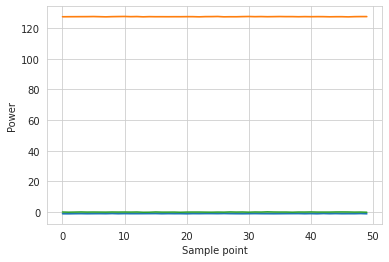

In [158]:
plot_longform(gen_trace(0))
plot_longform(gen_mask_trace())
plot_longform(gen_trace(256))

In [159]:
def match(key_byte=0):
    return device_fails(t_stat(gen_trace(key_byte)), t_stat(gen_trace(key_byte)), c_value), \
           device_fails(t_stat(gen_mask_trace()), t_stat(gen_mask_trace()), c_value)

tests = 1000

res = np.array([match() for kb in tqdm(range(tests))])
res.sum(axis=0)

100%|██████████| 1000/1000 [00:07<00:00, 132.11it/s]


array([37, 28])

Here might follow some statistical property analysis of this test.